### System

The total Hamiltonian of the system is given by:

$
H = H_0 + H_{\text{SB}} = H_{\text{S}} + H_{\text{B}} + H_{\text{SB}}
$

where:
- $ H_{\text{S}} $ is the system Hamiltonian
- $ H_{\text{B}} $ is the bath Hamiltonian
- $ H_{\text{SB}} $ is the system-bath interaction Hamiltonian

#### System Hamiltonian

The system Hamiltonian $ H_{\text{S}} $ is modeled as a two level system:

$
H_{\text{S}} = \hbar \omega_a |e\rangle\langle e|
$

is defined by a two level system with ground state $ |g\rangle $, seperated from an excited state $ |e\rangle $ by $ \omega_a $.
The atom is polarized in the z direction


### The Coupling to the Environment is modeled with 
#### The Redfield Equation

... derivation from paper / Danis darivation...


The system-bath coupling is written in a general form as:

$
H_{SB} =  \sum_i S_i \otimes B_i,
$

where the coupling operators $ S_i $  are modeled as $ \sigma_z $ for dephasing and $ \sigma_x $ for relaxation.
and the different baths are uncorrelated. The correlation functions thus can be written as: 

$
C_{ij}(t) \equiv \langle B_i(t) B_j \rangle_B \equiv \delta_{ij} \langle B_i(t) B_j \equiv C_i(t)
$

Each System operator couples to its own bath.

**The SB interaction is treated within a linear response theory**: The monomers are linearly coupled to the bath oscillators and the coupling function $ F_i $ is specified as:

$
B_i = \sum_x g_x^i q_x^i =\sum_x g_x^i (a_x^{\dagger} + a_x) 
$

where the coupling parameter $ g_x^i $ describe the interaction of the system operator with mode $ x $ of the $ i-th $ bath.

For a bath of harmonic oscillators, analytic expressions for the bath correlation function (CF) and its Fourier transform can be obtained:

$
C_i(t) = \frac{1}{2} \sum_x (g_x^{(i)})^2 \left[ n(\omega_x) e^{i\omega_x t} + (1 + n(\omega_x)) e^{-i\omega_x t} \right],
$

where $ n(\omega) = 1 / (e^{\hbar\omega/k_B T} - 1) $ is the Bose-Einstein distribution function.

The spectral density function, $ J_i(\omega) $, which entirely describes the parameters of the bath, is defined for each monomer as:

$
J_i(\omega) = \frac{\pi}{2} \sum_x (g_x^{(i)})^2 \delta(\omega - \omega_x).
$

For convenience, we assume that the spectral density for both monomers is equivalent. For the calculations in this paper, the spectral density is taken to be of the form:

$
J(\omega) = g^2 \frac{\omega}{\omega_{\text{c}}} e^{-\omega/\omega_{\text{c}}},
$

where $ \omega_{\text{c}} $ is a cutoff frequency and $ g^2 $ is a dimensionless coupling strength parameter.


In [1]:
### IMPORTS ###
from bath_constants import (
    Boltzmann,
    hbar,
    ############## Bath parameters ##############
    Temp,
    eta,
    cutoff,
    args_drude_lorentz,
    args_ohmic,
)
# functions from test_baths.py
from test_baths import (
    spectral_density_func_ohmic,
    spectral_density_func_drude_lorentz,
)
import matplotlib.pyplot as plt
from qutip import *
import numpy as np

# Import the outsourced plot settings
from plot_settings import *

In [ ]:
# =============================
# SYSTEM PARAMETERS     (**changeable**) 
# =============================
global Bath, omega_a, mu_a, rabi_0, delta
omega_a = 1 * 2 * np.pi # energy separation of the atomic states
mu_a = .1 * omega_a      # dipole moment of the transition
Bath = "OHMIC"          # Choose between "OHMIC" or DRUDE LORENTZ "DL"
if Bath == "OHMIC":
    bath_args = args_ohmic
    bath_model = spectral_density_func_ohmic
elif Bath == "DL":
    bath_args = args_drude_lorentz
    bath_model = spectral_density_func_drude_lorentz
else:
    raise ValueError("Invalid Bath type. Choose between 'OHMIC' or 'DL'.")

bath_args["cutoff"] = cutoff * omega_a # Adjust the cutoff frequency of the bath model based on the atomic frequency

### Define Atomic States and Hamiltonian
atom_g, atom_e = basis(2, 0), basis(2, 1)  # Ground, Excited states
sm = atom_g * atom_e.dag()
sx = (sm + sm.dag())/2  # sigmaX operator
sz = atom_e * atom_e.dag() - atom_g * atom_g.dag()  # sigmaZ operator
sy = -1j * (atom_e * atom_g.dag() - atom_g * atom_e.dag())  # sigmaY operator

psi_ini = (atom_e + atom_g).unit()   # initial state
H0 = hbar * omega_a/2 * sz

### Coupling to the bath
# Linblad Case
gamma_phi, gamma_0 = eta , eta / 3  # (**changeable**):  Dephasing and Decay rates with MESOLVE

sm_list = [(atom_g * atom_e.dag())]
SM_op = sum(sm_list)
Dip_op = SM_op + SM_op.dag()

bath_args_deph = bath_args.copy()
bath_args_deph["eta"] = np.sqrt(gamma_phi)
bath_args_rela = bath_args.copy()
bath_args_rela["eta"] = np.sqrt(gamma_0)

# to normalize the time; sort of mean decay rate
gamma_br = (bath_args_rela["eta"]) * 100
gamma_me = (gamma_0)
gamma_ratio = gamma_br / gamma_me

a_ops_list = [
    [sz, lambda w: bath_model(w, bath_args_deph)],   # Dephasing sz = Deph_op = ket2dm(atom_e) - ket2dm(atom_g)
#    [sx, lambda w: bath_model(w, bath_args_rela)],   # Relaxation sx = Rel_op = sm + sm.dag()
]

c_ops_list = [
    np.sqrt(gamma_phi) * sz,
#    np.sqrt(gamma_0) * SM_op,
]


e_ops_list = [
    sx, 
    #sy, 
    #sz, 
    ket2dm(atom_e)
] # [ket2dm(state) for state in H0.eigenstates()[1]]

e_ops_labels = [r"$ \langle s_x \rangle $ ", 
                #r"$ \langle s_y \rangle $ ", 
                #r"$ \langle s_z \rangle $ ", 
                r"$ \langle n \rangle $ "] # [fr"$|{i}\rangle$" for i in range(len(H0.eigenstates()[1]))]

 Total run time:   0.58s*] Elapsed 0.58s / Remaining 00:00:00:00
 Total run time:   0.92s*] Elapsed 0.91s / Remaining 00:00:00:00[          1%           ] Elapsed 0.02s / Remaining 00:00:00:01


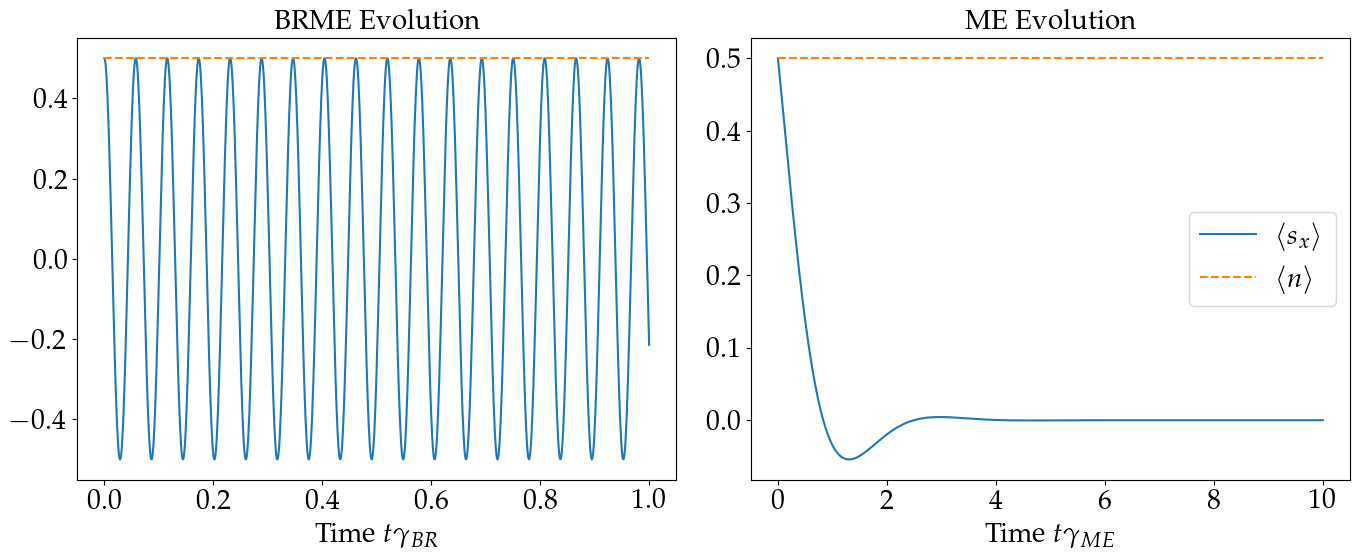

In [47]:
times_br = np.linspace(
    0, 1 / gamma_br, 1000
)  # High-resolution times array to do the evolutions
times_me = np.linspace(
    0, 10 / gamma_me, 1000
)  # High-resolution times array to do the evolutions

options = {
    "store_states": True,
    "progress_bar": "enhanced",
}  # Store states for further analysis

### compute the evolution
result_brme = brmesolve(
    H0,
    psi_ini,
    times_br,
    e_ops=e_ops_list,
    a_ops=a_ops_list,
    options=options,
)

result_me = mesolve(
    H0,
    psi_ini,
    times_me,
    e_ops=e_ops_list,
    c_ops=c_ops_list,
    options=options,
)
# =============================
# PLOT EVOLUTION
# =============================
plt.figure(figsize=(14, 6))

### Plot result_brme
plt.subplot(1, 2, 1)
for i, e_op in enumerate(e_ops_list):
    plt.plot(
        np.array(result_brme.times) * gamma_br,
        result_brme.expect[i],
        label=e_ops_labels[i],
        linestyle=['solid', 'dashed', 'dashdot', 'dotted'][i % 4],  # Alternate line styles
        color=f'C{i}',  # Use distinct colors
    )
plt.xlabel(r'Time $t \gamma_{BR}$')
plt.title(r'BRME Evolution')

### Plot result_me
plt.subplot(1, 2, 2)
for i, e_op in enumerate(e_ops_list):
    plt.plot(
        np.array(result_me.times) * gamma_me,
        result_me.expect[i],
        label=e_ops_labels[i],
        linestyle=['solid', 'dashed', 'dashdot', 'dotted'][i % 4],  # Alternate line styles
        color=f'C{i}',  # Use distinct colors
    )
plt.xlabel(r'Time $t \gamma_{ME}$')
plt.title(r'ME Evolution')
plt.legend()

plt.tight_layout()
plt.show()